# Load Data

In [42]:
import pandas as pd
import numpy as np

train_file = r"..\01 Dataset\03 Data for model\Train_set.csv"
test_file  = r"..\01 Dataset\03 Data for model\Test_set.csv"

df_train = pd.read_csv(train_file)
df_test  = pd.read_csv(test_file)

In [43]:
print("Raw train shape :", df_train.shape)
print("Raw test shape  :", df_test.shape)

Raw train shape : (367767, 54)
Raw test shape  : (94946, 54)


In [44]:
# Check unique values for object columns to determine encoding strategy

# Select columns with data type 'object' (commonly used for categorical features)
object_cols = df_test.select_dtypes(include=['object']).columns

# Iterate over each object-type column
for col in object_cols:

    # Print the column name and the number of unique values (categories) it has
    print(f"{col}: {df_test[col].nunique()} unique values")

    # If the column has fewer than 20 unique values, print the actual unique categories
    if df_test[col].nunique() < 20:
        print(df_test[col].unique())

    print("-" * 20)

household_ID: 182 unique values
--------------------
DATE: 366 unique values
--------------------
TIME: 9968 unique values
--------------------
own_the_house_or_living_on_rent: 3 unique values
['Yes, I or a household member owns it.'
 'No, I am living on rent and the rent is paid by me or a household member.'
 'No, I or any household member does not own or rent this household. We occupy this household without any payment of rent.']
--------------------
built_year_of_the_house: 7 unique values
['2010-2019' "Don't know" '2000-2009' '1990-1999' 'Before 1980'
 '1980-1989' 'In 2020 or After 2020']
--------------------
type_of_house: 7 unique values
['Single House - Double Floor' 'Single House - Single Floor' 'Twin houses'
 'Flat' 'Single House - More than 2 floors' 'Slum / Shanty'
 'Line room/row house']
--------------------
is_there_business_carried_out_in_the_household: 2 unique values
['Yes' 'No']
--------------------
socio_economic_class: 5 unique values
['SEC C' 'SEC D' 'SEC B' 'SEC A'

# Data Preprocessing

In [45]:
#Drop useless columns
useless_cols = ['household_ID', 'DATE', 'TIME', 'timestamp', 
            'sawdust_or_paddy_husk_used_for_cooking', 'biogas_used_for_cooking']

df_train_clean = df_train.drop(columns=useless_cols)
df_test_clean  = df_test.drop(columns=useless_cols)

print("After dropping useless cols – train:", df_train_clean.shape)

After dropping useless cols – train: (367767, 48)


In [46]:
def create_cyclical_features(df):
    df_copy = df.copy()

    # ----- Encode "hour" into cyclical representation -----
    # hour_sin = sin(2π * hour / 24)
    # hour_cos = cos(2π * hour / 24)
    if 'hour' in df_copy.columns:
        df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
        df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)

        # Remove the original hour column to avoid duplicated information
        df_copy = df_copy.drop(columns=['hour'])

    # ----- Encode "month" into cyclical representation -----
    # month_sin = sin(2π * month / 12)
    # month_cos = cos(2π * month / 12)
    if 'month' in df_copy.columns:
        df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
        df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)

        # Remove the original month column
        df_copy = df_copy.drop(columns=['month'])

    return df_copy

# Apply cyclical encoding to both training and testing sets
df_train_clean = create_cyclical_features(df_train_clean)
df_test_clean  = create_cyclical_features(df_test_clean)

print("After cyclical features – train:", df_train_clean.shape)

After cyclical features – train: (367767, 50)


In [47]:
# Separate features (X) and target variable (y)
X_train = df_train_clean.drop(columns='future_6h_consumption')
y_train = df_train_clean['future_6h_consumption']

X_test = df_test_clean.drop(columns='future_6h_consumption')
y_test = df_test_clean['future_6h_consumption']

# If there are any missing targets in train, drop those rows
mask = y_train.notna()
X_train = X_train[mask]
y_train = y_train[mask]

print("Final X_train shape:", X_train.shape)
print("Final X_test  shape:", X_test.shape)
print("=== y train ===")
print(y_train.describe())
print("=== y test ===")
print(y_test.describe())

Final X_train shape: (367767, 49)
Final X_test  shape: (94946, 49)
=== y train ===
count    367767.000000
mean          1.191558
std           1.381539
min           0.000900
25%           0.506000
50%           0.847000
75%           1.353000
max          19.998000
Name: future_6h_consumption, dtype: float64
=== y test ===
count    94946.000000
mean         1.055836
std          1.128391
min          0.000900
25%          0.469100
50%          0.790000
75%          1.255000
max         19.993900
Name: future_6h_consumption, dtype: float64


In [48]:
# Define numeric / categorical feature lists
numeric_features_train     = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features_train = X_train.select_dtypes(include=['object']).columns

numeric_features_test     = X_test.select_dtypes(include=['int64', 'float64']).columns
categorical_features_test = X_test.select_dtypes(include=['object']).columns

print(f"Numeric features: train={len(numeric_features_train)}, test={len(numeric_features_test)}")
print(f"Categorical features: train={len(categorical_features_train)}, test={len(categorical_features_test)}")

Numeric features: train=34, test=34
Categorical features: train=15, test=15


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Build preprocessing pipelines
# Numeric: Impute missing with Median, Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Impute missing with Mode, One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric + categorical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_train),
        ('cat', categorical_transformer, categorical_features_train)
    ])

# Lasso model

In [50]:
# Build and train LassoCV model inside a Pipeline
lasso_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LassoCV(cv=5, random_state=42, n_jobs=-1))
])

lasso_model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = lasso_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Lasso – Test ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

=== Lasso – Test ===
RMSE: 0.8590
MAE: 0.4547
R2 Score: 0.4204


In [51]:
# Check best alpha
best_alpha = lasso_model.named_steps['regressor'].alpha_
print(f"Best Alpha: {best_alpha}")

# Check feature selection (count non-zero coefficients)
# Get feature names after one-hot encoding
feature_names = (lasso_model.named_steps['preprocessor']
                 .transformers_[0][1].get_feature_names_out(numeric_features_train).tolist() + 
                 lasso_model.named_steps['preprocessor']
                 .transformers_[1][1].get_feature_names_out(categorical_features_train).tolist())

# Coefficients from Lasso
coefs = lasso_model.named_steps['regressor'].coef_
selected_features = np.sum(coefs != 0)
total_features = len(coefs)

print(f"Selected Features: {selected_features} out of {total_features}")

Best Alpha: 0.06436015716520689
Selected Features: 14 out of 93


In [52]:
# Create a dataframe of top features
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 10 Features (Lasso):")
print(feature_importance.head(13))


Top 10 Features (Lasso):
                                    Feature  Coefficient  Abs_Coefficient
19                        w1_total_room_acs     0.518353         0.518353
0                        TOTAL_IMPORT (kWh)     0.441005         0.441005
30                                 hour_sin    -0.119623         0.119623
1                        w1_hh_member_count     0.064334         0.064334
17                      w1_total_room_bulbs     0.060965         0.060965
22  total_monthly_expenditure_of_last_month     0.058813         0.058813
31                                 hour_cos    -0.051783         0.051783
33                                month_cos    -0.047923         0.047923
21                               floor_area     0.031099         0.031099
18                       w1_total_room_fans     0.012153         0.012153
16                       w1_total_doors_ext     0.009007         0.009007
13                     w1_light_hours_night     0.002148         0.002148
24          

# Ridge Model

In [53]:
from sklearn.linear_model import RidgeCV

# Build Ridge pipeline
ridge_model = Pipeline(steps=[
    ("preprocessor", preprocessor),          # same preprocessing
    ("regressor", RidgeCV(
        alphas=np.logspace(-3, 3, 20),      # search alpha from 1e-3 to 1e3
        cv=5
    ))
])

# Fit model
ridge_model.fit(X_train, y_train)

# Predict on test set
y_pred_ridge = ridge_model.predict(X_test)


In [54]:
# Evaluate performance
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge  = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge   = r2_score(y_test, y_pred_ridge)

print("=== Ridge – Test ===")
print(f"RMSE : {rmse_ridge:.4f}")
print(f"MAE  : {mae_ridge:.4f}")
print(f"R^2  : {r2_ridge:.4f}")

=== Ridge – Test ===
RMSE : 0.8622
MAE  : 0.4778
R^2  : 0.4161


In [55]:
# check best alpha
best_alpha_ridge = ridge_model.named_steps["regressor"].alpha_
print(f"\nBest Alpha (Ridge): {best_alpha_ridge:.6f}")


Best Alpha (Ridge): 1000.000000


In [56]:
# 6. Ridge coefficients + feature names
num_feature_names_r = (
    ridge_model.named_steps["preprocessor"]
    .transformers_[0][1]
    .get_feature_names_out(numeric_features_train)
)
cat_feature_names_r = (
    ridge_model.named_steps["preprocessor"]
    .transformers_[1][1]
    .get_feature_names_out(categorical_features_train)
)
feature_names_ridge = np.concatenate([num_feature_names_r, cat_feature_names_r])

coefs_ridge = ridge_model.named_steps["regressor"].coef_

# Make a dataframe of feature importance
feature_importance_ridge = pd.DataFrame({
    "Feature": feature_names_ridge,
    "Coefficient": coefs_ridge
})
feature_importance_ridge["Abs_Coefficient"] = feature_importance_ridge["Coefficient"].abs()
feature_importance_ridge = feature_importance_ridge.sort_values(
    by="Abs_Coefficient", ascending=False
)

print("\nTop 10 Features (Ridge):")
print(feature_importance_ridge.head(10))


Top 10 Features (Ridge):
                                              Feature  Coefficient  \
19                                  w1_total_room_acs     0.526045   
0                                  TOTAL_IMPORT (kWh)     0.473422   
24                           backward_avg_consumption     0.422211   
64  method_of_receiving_water_Tap Water (Local Gov...     0.414388   
25                             consumption_per_member    -0.379286   
48                  type_of_house_Line room/row house     0.333163   
50    type_of_house_Single House - More than 2 floors     0.298324   
71  water_heating_method_for_bathing_We have a wat...     0.200049   
49          type_of_house_Single House - Double Floor    -0.192558   
70  water_heating_method_for_bathing_We don't have...    -0.178712   

    Abs_Coefficient  
19         0.526045  
0          0.473422  
24         0.422211  
64         0.414388  
25         0.379286  
48         0.333163  
50         0.298324  
71         0.200049  
49   

# Elastic Net Model

In [57]:
from sklearn.linear_model import ElasticNetCV

# Build Elastic Net pipeline
# ElasticNetCV will search for the best alpha and l1_ratio
elastic_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],  # mix of L1 and L2
        cv=5,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit model
elastic_model.fit(X_train, y_train)

# Predict on test set
y_pred_elastic = elastic_model.predict(X_test)

In [58]:
# Evaluate performance
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
mae_elastic  = mean_absolute_error(y_test, y_pred_elastic)
r2_elastic   = r2_score(y_test, y_pred_elastic)

print("=== Elastic Net – Test ===")
print(f"RMSE : {rmse_elastic:.4f}")
print(f"MAE  : {mae_elastic:.4f}")
print(f"R^2  : {r2_elastic:.4f}")

# Check best alpha and l1_ratio chosen by ElasticNetCV
best_alpha_en   = elastic_model.named_steps["regressor"].alpha_
best_l1_ratio   = elastic_model.named_steps["regressor"].l1_ratio_
print(f"\nBest Alpha   (Elastic Net): {best_alpha_en:.6f}")
print(f"Best l1_ratio(Elastic Net): {best_l1_ratio:.3f}")

=== Elastic Net – Test ===
RMSE : 0.8589
MAE  : 0.4545
R^2  : 0.4206

Best Alpha   (Elastic Net): 0.071511
Best l1_ratio(Elastic Net): 0.900


In [59]:
# Inspect feature importance
num_feature_names_en = (
    elastic_model.named_steps["preprocessor"]
    .transformers_[0][1]
    .get_feature_names_out(numeric_features_train)
)

cat_feature_names_en = (
    elastic_model.named_steps["preprocessor"]
    .transformers_[1][1]
    .get_feature_names_out(categorical_features_train)
)

feature_names_en = np.concatenate([num_feature_names_en, cat_feature_names_en])

coefs_en = elastic_model.named_steps["regressor"].coef_

feature_importance_en = pd.DataFrame({
    "Feature": feature_names_en,
    "Coefficient": coefs_en
})
feature_importance_en["Abs_Coefficient"] = feature_importance_en["Coefficient"].abs()
feature_importance_en = feature_importance_en.sort_values(
    by="Abs_Coefficient", ascending=False
)

print("\nTop 10 Features (Elastic Net):")
print(feature_importance_en.head(10))


Top 10 Features (Elastic Net):
                                    Feature  Coefficient  Abs_Coefficient
19                        w1_total_room_acs     0.514123         0.514123
0                        TOTAL_IMPORT (kWh)     0.438869         0.438869
30                                 hour_sin    -0.116603         0.116603
1                        w1_hh_member_count     0.063851         0.063851
17                      w1_total_room_bulbs     0.061615         0.061615
22  total_monthly_expenditure_of_last_month     0.058750         0.058750
31                                 hour_cos    -0.054246         0.054246
33                                month_cos    -0.047566         0.047566
21                               floor_area     0.032044         0.032044
18                       w1_total_room_fans     0.011869         0.011869


In [60]:
#Output the L1 ratio
print(elastic_model.named_steps['regressor'].l1_ratio_)

0.9


# Save the Results

In [61]:
# Select Best Model 
results = {
    "lasso":   r2,
    "ridge":   r2_ridge,
    "elastic": r2_elastic
}

best_model_name = max(results, key=results.get)
print(f"Best Model: {best_model_name}  (R² = {results[best_model_name]:.4f})")

# Map name → model reference
model_dict = {
    "lasso": lasso_model,
    "ridge": ridge_model,
    "elastic": elastic_model
}

best_model = model_dict[best_model_name]

# Predict Again with the Best Model
y_pred_best = best_model.predict(X_test)

# Create DataFrame
df_result = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred_best,
    "abs_error": np.abs(y_test.values - y_pred_best)
})

print(df_result.head())

# Save to CSV
output_name = f"best_model_predictions_{best_model_name}.csv"
df_result.to_csv(output_name, index=False)


Best Model: elastic  (R² = 0.4206)
   y_test    y_pred  abs_error
0   0.810  0.771859   0.038141
1   0.616  1.069715   0.453715
2   0.558  0.719925   0.161925
3   0.583  0.679817   0.096817
4   1.085  0.962730   0.122270


# Draw Plots

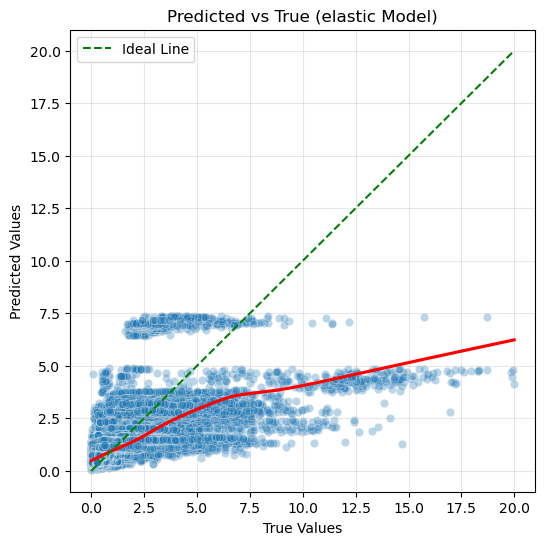

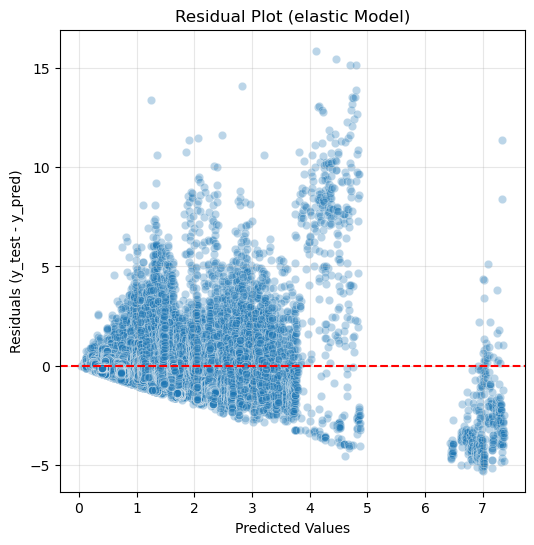

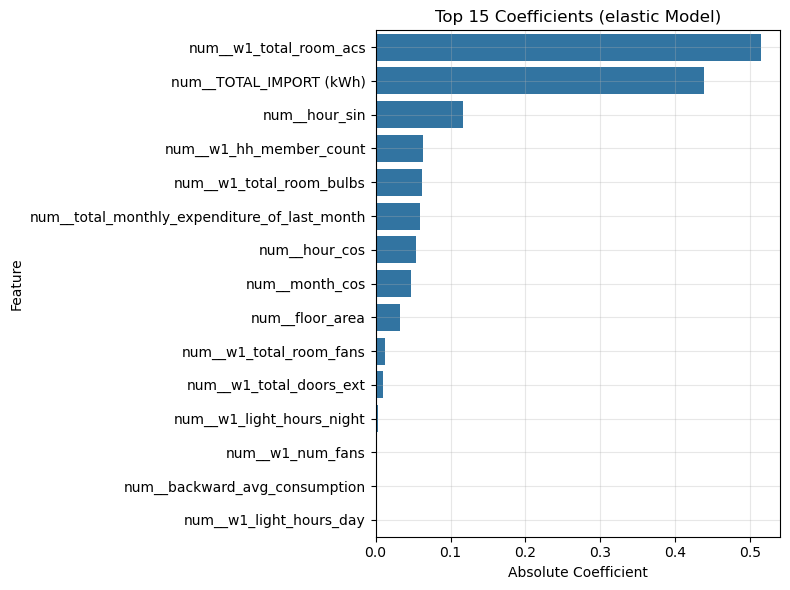

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Residuals ----------
residuals = y_test.values - y_pred_best

# ---------- Predicted vs True ----------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.3)
sns.regplot(x=y_test, y=y_pred_best, scatter=False, lowess=True, color='red')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'g--', label='Ideal Line')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs True ({best_model_name} Model)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---------- Residual Plot ----------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title(f"Residual Plot ({best_model_name} Model)")
plt.grid(alpha=0.3)
plt.show()

# ----------  Top 15 Coefficients with names ----------
preprocessor = best_model.named_steps['preprocessor']
regressor = best_model.named_steps['regressor']

feature_names = preprocessor.get_feature_names_out()
coefs = regressor.coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
})
coef_df["Abs"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs", ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=coef_df, x="Abs", y="Feature")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.title(f"Top 15 Coefficients ({best_model_name} Model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()